- Loan_ID --> Loan ID
- Gender 
- Married Status
- Dependents
- Education (Graduate/UnderGraduate)
- Self Employed
- Applicant Income
- co-aaplicant Income
- LoanAmount
- Loan_Amount_Term 
- Credit History
- Property Area (Urban/Semi/ Rural)
- Loan_Status (Loan Approved Y/N)

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Models

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

## Set theme
sns.set(context = 'notebook', style = 'darkgrid', palette = 'deep', \
        font = 'sans-serif', font_scale = 1, color_codes = False, rc = None)

In [3]:
import os
os.listdir(".")

['.ipynb_checkpoints',
 'loanDataset.ipynb',
 'test_Y3wMUE5_7gLdaTN.csv',
 'train_u6lujuX_CVtuZ9i.csv']

In [43]:
tr_df = pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
te_df = pd.read_csv("test_Y3wMUE5_7gLdaTN.csv")
display(tr_df.head())
display(te_df.head())

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [7]:
print("Training :{}, Test: {}".format(tr_df.shape, te_df.shape))

Training :(614, 13), Test: (367, 12)


In [8]:
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [44]:
tr_df.drop("Loan_ID", axis=1, inplace=True)
te_df.drop("Loan_ID", axis=1, inplace=True)

In [45]:
tr_df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [46]:
null_mode = ['Credit_History','Self_Employed','Dependents','Gender','Loan_Amount_Term',\
            'Married','Education','Property_Area']
null_median = ['LoanAmount']

In [47]:
for col in null_mode:
    filled_by = tr_df[col].dropna().mode().values[0]
    tr_df[col] = tr_df[col].fillna(filled_by)
    te_df[col] = te_df[col].fillna(filled_by)

In [48]:
for col in null_median:
    filled_by = tr_df['LoanAmount'].dropna().median()
    tr_df[col] = tr_df[col].fillna(filled_by)
    te_df[col] = te_df[col].fillna(filled_by)

In [49]:
assert tr_df.isnull().sum().sum()==0
assert te_df.isnull().sum().sum()==0

In [12]:
def get_vc(df,col):
    print("COL: {}".format(col))
    display(df[col].value_counts())

In [28]:
get_vc(tr_df,'Property_Area')

COL: Property_Area


Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

In [14]:
get_vc(tr_df,'Self_Employed')

COL: Self_Employed


No     500
Yes     82
Name: Self_Employed, dtype: int64

In [11]:
tr_df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

#### Data Vis

#### Loan Status Distribution

In [51]:
num = tr_df.select_dtypes('number').columns.to_list()
cat = tr_df.select_dtypes('object').columns.to_list()

loan_num = tr_df[num]
loan_cat = tr_df[cat]

C:\Users\aakashgoel\Anaconda3\envs\conda_env_1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


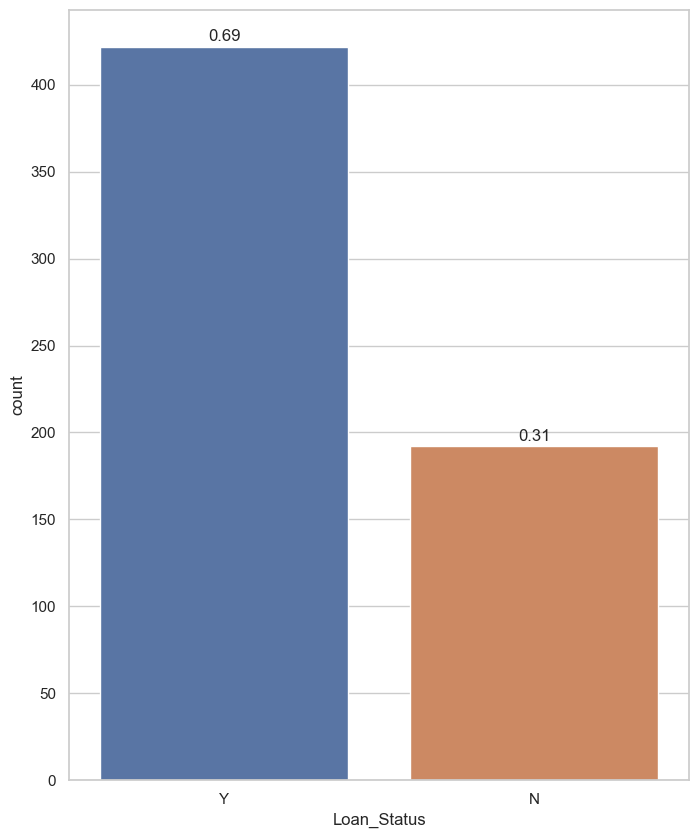

In [55]:
total = float(len(tr_df[cat[-1]]))
plt.figure(figsize=(8,10))
sns.set(style='whitegrid')
ax = sns.countplot(tr_df[cat[-1]])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, height+3, '{:1.2f}'.format(height/total), ha = 'center')

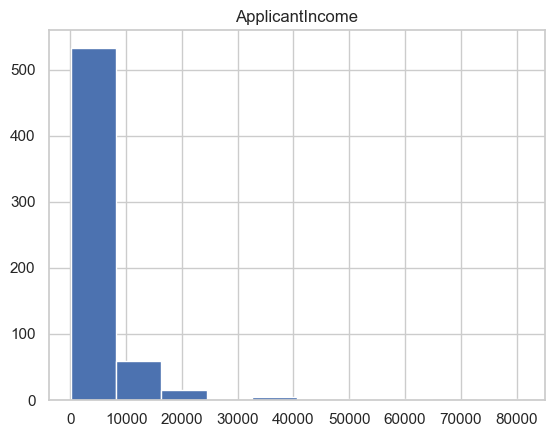

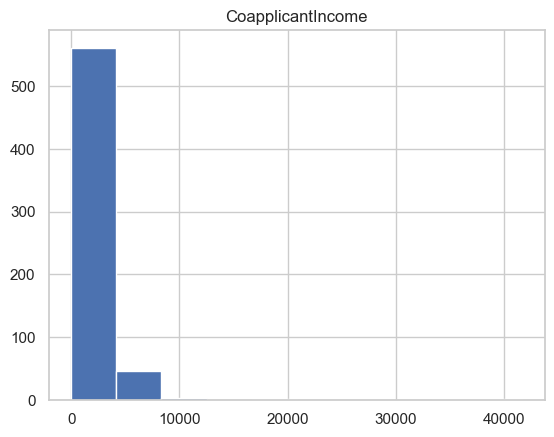

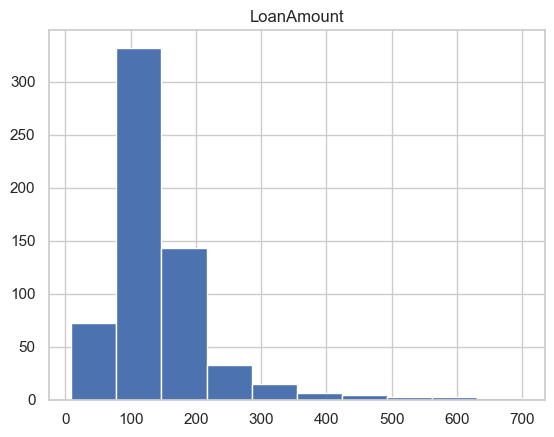

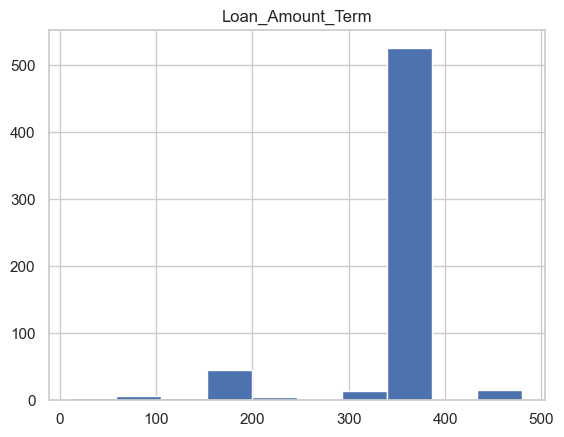

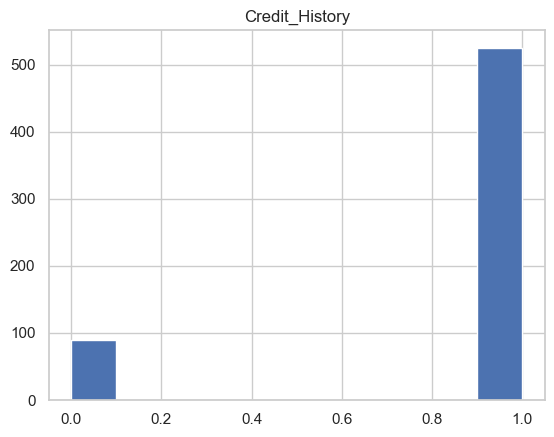

In [56]:
for i in loan_num:
    plt.hist(loan_num[i])
    plt.title(i)
    plt.show()

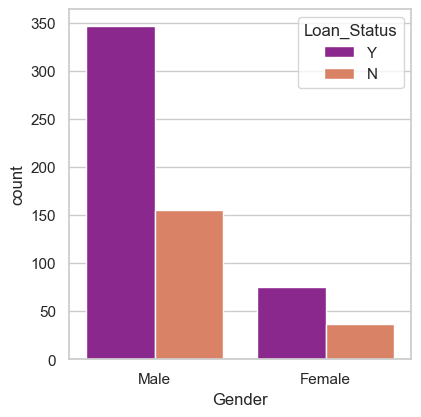

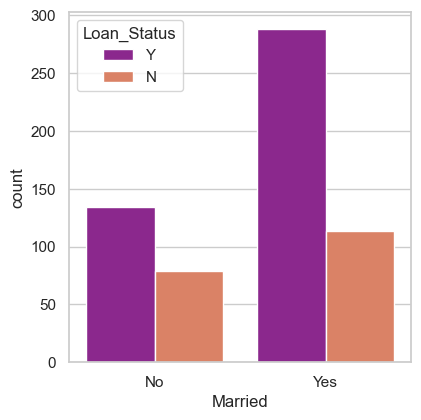

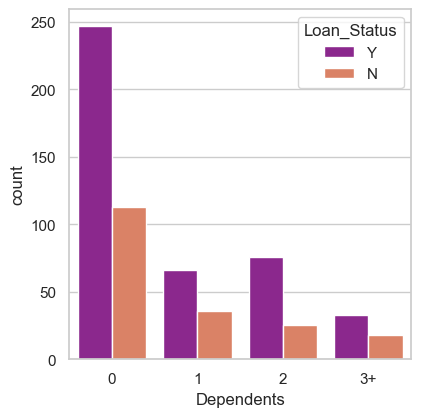

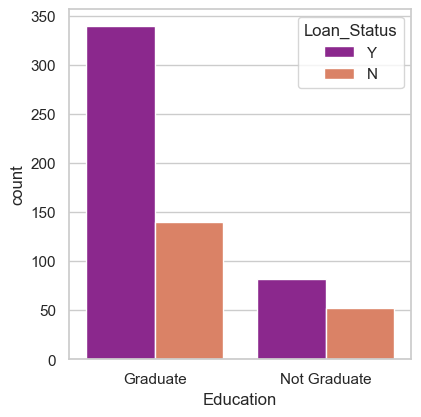

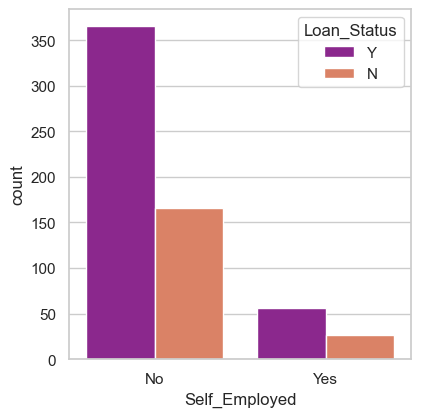

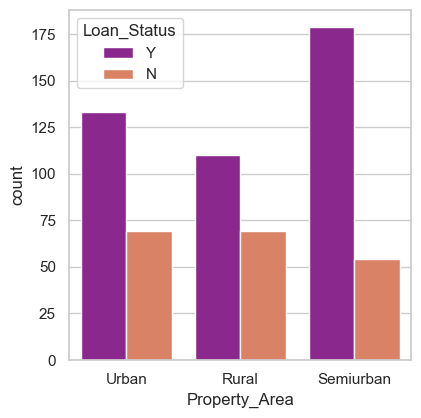

In [59]:
for i in cat[:-1]:
    plt.figure(figsize=(15,10))
    plt.subplot(2,3,1)
    sns.countplot(x = i, hue='Loan_Status',data=tr_df, palette='plasma')

### Data Encoding

In [60]:
to_numeric = {"Male":1, "Female":2,\
             "Yes":1,"No":2,\
             "Graduate":1, "Not Graduate":2,\
             "Urban":3,"Semiurban":2, "Rural":1,\
             "Y":1, "N":0,\
             "3+":3}

In [62]:
tr_df = tr_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)
te_df = te_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)

In [64]:
tr_df.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,2,0,1,2,5849,0.0,128.0,360.0,1.0,3,1
1,1,1,1,1,2,4583,1508.0,128.0,360.0,1.0,1,0


In [66]:
tr_df['Dependents'] =  pd.to_numeric(tr_df.Dependents)
te_df['Dependents'] =  pd.to_numeric(te_df.Dependents)

In [68]:
te_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             367 non-null    int64  
 1   Married            367 non-null    int64  
 2   Dependents         367 non-null    int64  
 3   Education          367 non-null    int64  
 4   Self_Employed      367 non-null    int64  
 5   ApplicantIncome    367 non-null    int64  
 6   CoapplicantIncome  367 non-null    int64  
 7   LoanAmount         367 non-null    float64
 8   Loan_Amount_Term   367 non-null    float64
 9   Credit_History     367 non-null    float64
 10  Property_Area      367 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 31.7 KB


<AxesSubplot:>

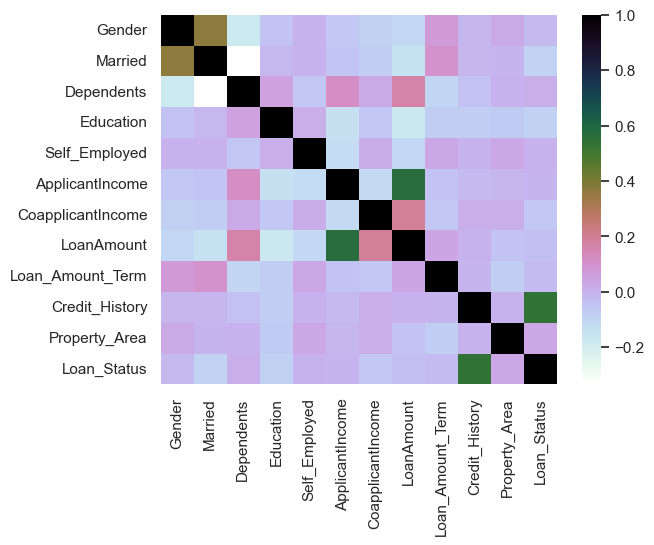

In [69]:
sns.heatmap(tr_df.corr(), cmap = 'cubehelix_r')

In [70]:
corr = tr_df.corr()
corr.style.background_gradient(cmap = "coolwarm").set_precision(2)

C:\Users\aakashgoel\AppData\Local\Temp\ipykernel_49668\4251024305.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap = "coolwarm").set_precision(2)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,1.00,0.36,-0.17,-0.05,-0.00,-0.06,-0.08,-0.11,0.07,-0.01,0.03,-0.02
Married,0.36,1.00,-0.33,-0.01,0.00,-0.05,-0.08,-0.15,0.10,-0.01,-0.00,-0.09
Dependents,-0.17,-0.33,1.00,0.06,-0.06,0.12,0.03,0.16,-0.10,-0.04,-0.00,0.01
Education,-0.05,-0.01,0.06,1.00,0.01,-0.14,-0.06,-0.17,-0.07,-0.07,-0.07,-0.09
Self_Employed,-0.00,0.00,-0.06,0.01,1.00,-0.13,0.02,-0.12,0.03,0.00,0.03,0.00
ApplicantIncome,-0.06,-0.05,0.12,-0.14,-0.13,1.00,-0.12,0.57,-0.05,-0.02,-0.01,-0.00
CoapplicantIncome,-0.08,-0.08,0.03,-0.06,0.02,-0.12,1.00,0.19,-0.06,0.01,0.01,-0.06
LoanAmount,-0.11,-0.15,0.16,-0.17,-0.12,0.57,0.19,1.00,0.04,-0.00,-0.05,-0.03
Loan_Amount_Term,0.07,0.10,-0.10,-0.07,0.03,-0.05,-0.06,0.04,1.00,-0.00,-0.08,-0.02
Credit_History,-0.01,-0.01,-0.04,-0.07,0.00,-0.02,0.01,-0.00,-0.00,1.00,0.00,0.54


### Modelling 

In [71]:
y = tr_df['Loan_Status']
X = tr_df.drop('Loan_Status', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 42)

In [74]:
from sklearn.metrics import f1_score

In [76]:
def get_classification_report(actual, predicted):
    print("Classification Report: \n")
    print(classification_report(actual, predicted))
    print("Accuracy : {}".format(accuracy_score(actual, predicted)))
    f1score = f1_score(actual, predicted)
    print("F1: {}".format(f1score))
    return f1score

In [77]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_predict = dt.predict(X_test)
dt_f1 = get_classification_report(y_test, y_predict)

Classification Report: 

              precision    recall  f1-score   support

           0       0.51      0.54      0.52        65
           1       0.74      0.72      0.73       120

    accuracy                           0.65       185
   macro avg       0.62      0.63      0.63       185
weighted avg       0.66      0.65      0.66       185

Accuracy : 0.654054054054054
F1: 0.728813559322034


In [78]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
rf_f1 = get_classification_report(y_test, y_predict)

Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.51      0.63        65
           1       0.78      0.94      0.85       120

    accuracy                           0.79       185
   macro avg       0.80      0.72      0.74       185
weighted avg       0.80      0.79      0.77       185

Accuracy : 0.7891891891891892
F1: 0.8528301886792453


In [79]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_predict = xgb.predict(X_test)
xgb_f1 = get_classification_report(y_test, y_predict)

Classification Report: 

              precision    recall  f1-score   support

           0       0.70      0.48      0.57        65
           1       0.76      0.89      0.82       120

    accuracy                           0.75       185
   macro avg       0.73      0.68      0.69       185
weighted avg       0.74      0.75      0.73       185

Accuracy : 0.745945945945946
F1: 0.8199233716475095


In [80]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
lr_f1 = get_classification_report(y_test, y_predict)

Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.43      0.58        65
           1       0.76      0.97      0.85       120

    accuracy                           0.78       185
   macro avg       0.82      0.70      0.71       185
weighted avg       0.80      0.78      0.75       185

Accuracy : 0.7783783783783784
F1: 0.8498168498168498


C:\Users\aakashgoel\Anaconda3\envs\conda_env_1\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
y_predict = svm_model.predict(X_test)
svm_f1 = get_classification_report(y_test, y_predict)

Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.65      1.00      0.79       120

    accuracy                           0.65       185
   macro avg       0.32      0.50      0.39       185
weighted avg       0.42      0.65      0.51       185

Accuracy : 0.6486486486486487
F1: 0.7868852459016393


C:\Users\aakashgoel\Anaconda3\envs\conda_env_1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aakashgoel\Anaconda3\envs\conda_env_1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aakashgoel\Anaconda3\envs\conda_env_1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [82]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_predict = nb.predict(X_test)
nb_f1 = get_classification_report(y_test, y_predict)

Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.45      0.59        65
           1       0.76      0.97      0.85       120

    accuracy                           0.78       185
   macro avg       0.82      0.71      0.72       185
weighted avg       0.80      0.78      0.76       185

Accuracy : 0.7837837837837838
F1: 0.8529411764705883


In [83]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_predict = gb.predict(X_test)
gb_f1 = get_classification_report(y_test, y_predict)

Classification Report: 

              precision    recall  f1-score   support

           0       0.81      0.38      0.52        65
           1       0.74      0.95      0.83       120

    accuracy                           0.75       185
   macro avg       0.77      0.67      0.68       185
weighted avg       0.76      0.75      0.72       185

Accuracy : 0.7513513513513513
F1: 0.8321167883211679


In [84]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
knn_f1 = get_classification_report(y_test, y_predict)

Classification Report: 

              precision    recall  f1-score   support

           0       0.35      0.17      0.23        65
           1       0.65      0.83      0.73       120

    accuracy                           0.60       185
   macro avg       0.50      0.50      0.48       185
weighted avg       0.55      0.60      0.55       185

Accuracy : 0.6
F1: 0.72992700729927


### Conclude/Compare

In [85]:
models = pd.DataFrame({"Models":["NB","LR","KNN","SVM","DT","RF","GB","XGB"],\
                      "F1":[nb_f1,lr_f1,knn_f1,svm_f1,dt_f1,rf_f1,gb_f1,xgb_f1]})
models

,Models,F1
0,NB,0.852941
1,LR,0.849817
2,KNN,0.729927
3,SVM,0.786885
4,DT,0.728814
5,RF,0.852830
6,GB,0.832117
7,XGB,0.819923


In [86]:
models.sort_values(by='F1',ascending=False)

,Models,F1
0,NB,0.852941
5,RF,0.852830
1,LR,0.849817
6,GB,0.832117
7,XGB,0.819923
3,SVM,0.786885
2,KNN,0.729927
4,DT,0.728814
